<a href="https://colab.research.google.com/github/yashsingla984/CP-Vton-cloth-masking/blob/main/Extractdresses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2 as cv
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/shopcom

from keras.applications import vgg16, resnet50
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model, load_model
from keras.applications.imagenet_utils import preprocess_input
import tensorflow

from PIL import Image
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import pickle

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/shopcom


Using TensorFlow backend.


In [ ]:
### DEFINE GRABCUT FUNCTION ###

def cut(img):

    img = cv.resize(img,(224,224))
    
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    height, width = img.shape[:2]

    rect = (50,10,width-100,height-20)
    cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img2 = img*mask2[:,:,np.newaxis]
    img2[mask2 == 0] = (255, 255, 255)
    
    final = np.ones(img.shape,np.uint8)*0 + img2
    
    return mask, final

In [ ]:
### LOAD PRETRAINED UNET ###
UNET = tensorflow.keras.models.load_model('./fashion_unet.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


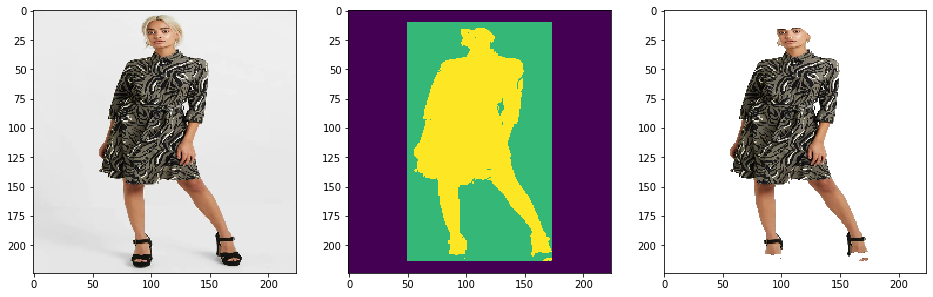

In [ ]:
### APPLY GRUBCUT ###
plt.figure(figsize=(16,8))
original = cv.imread('test1.jpg')
original = cv.resize(original,(224,224))

plt.subplot(1,3,1)
plt.imshow(cv.cvtColor(original, cv.COLOR_BGRA2RGB))
mask, final = cut(original)
plt.subplot(1,3,2)
plt.imshow(mask)
plt.subplot(1,3,3)
plt.imshow(cv.cvtColor(final, cv.COLOR_BGRA2RGB))

In [ ]:
### LOAD MEAN PIXEL ARRAY TO STANDARDIZE NEW IMAGES ###
with open("./mean81.pkl", 'rb') as pickle_file:
    mean = pickle.load(pickle_file)

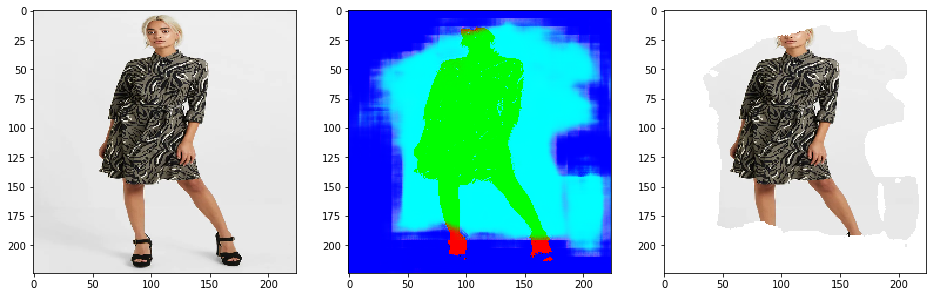

In [ ]:
### READ NEW IMAGE ###
plt.figure(figsize=(16,8))
img = cv.imread('test1.jpg')
plt.subplot(1,3,1)
plt.imshow(cv.cvtColor(cv.resize(img.copy(),(224,224)), cv.COLOR_BGRA2RGB))

### GRUBCUT + PREDICTION ###
mask_test, test = cut(img)
test = test - mean.reshape(-1,224,224,3)
pred = UNET.predict(test)[0]
plt.subplot(1,3,2)
plt.imshow(pred)

### APPLY PIXEL TRESHOLD FOR MASK ###
pred_dress = pred.copy()[:,:,1]
pred_dress[pred_dress>=0.90]=1
pred_dress[pred_dress<0.90]=0
real_dress = (cv.resize(img.copy(),(224,224))*pred_dress[:,:,np.newaxis]).astype('int')
real_dress[pred_dress == 0] = (255, 255, 255)
plt.subplot(1,3,3)
plt.imshow(cv.cvtColor(real_dress.astype('uint8'), cv.COLOR_BGRA2RGB))